# Table of contents


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpat
import matplotlib.transforms as trans
from matplotlib import ticker, cm
from utility import analysis_parameters as ap, util
import numpy as np
import dask
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

In [2]:
region="TWP"
diff=False
n=0.25

# Load variables

In [3]:
chunk_dict = {"time":500, "lat":400, "lon":1440} # "grid_size":500000}
chunk_dictn = {"time":100, "ncells":100} 
chunk_dicts = {"time":500, "ncol":1000, "grid_size":1000} 

sa_olr = xr.open_dataset(ap.get_file("SAM", "TWP", "rlt"), chunks=chunk_dict).rlt
sa_swn = xr.open_dataset(ap.get_file("SAM", "TWP", "rst"), chunks=chunk_dict).rstacc
ds = xr.open_dataset(ap.get_file("DATA", "TWP", "rad"), chunks=chunk_dict)
da_olr = ds.adj_atmos_lw_up_all_toa_1h
da_swu = ds.adj_atmos_sw_up_all_toa_1h
da_swd = ds.adj_atmos_sw_down_all_toa_1h
# ni_olr = xr.open_dataset(ap.get_file("NICAM", "TWP", "rlut"), chunks=chunk_dict).rlut
# ni_swu = xr.open_dataset(ap.get_file("NICAM", "TWP", "rsut"), chunks=chunk_dict).rsut
# ni_swd = xr.open_dataset(ap.get_file("NICAM", "TWP", "rsdt"), chunks=chunk_dict).rsdt
um_olr = xr.open_dataset(ap.get_file("UM", "TWP", "rlut"), chunks=chunk_dict).rlut
um_swu = xr.open_dataset(ap.get_file("UM", "TWP", "rsut"), chunks=chunk_dict).rsut
um_swd = xr.open_dataset(ap.get_file("UM", "TWP", "rsdt"), chunks=chunk_dict).rsdt

# get coarsened model data for GEOS, SCREAM, and ARP
if n>0:
    ge_olr = xr.open_dataset(ap.get_file("GEOSr0.1deg", "TWP", "rlut"), chunks=chunk_dict).rlut
    ge_swu = xr.open_dataset(ap.get_file("GEOSr0.1deg", "TWP", "rsut"), chunks=chunk_dict).rsut
    ge_swd = xr.open_dataset(ap.get_file("GEOSr0.1deg", "TWP", "rsdt"), chunks=chunk_dict).rsdt
    sc_olr = xr.open_dataset(ap.get_file("SCREAMr0.1deg", "TWP", "rlt"), chunks=chunk_dict).rlt
    sc_swn = xr.open_dataset(ap.get_file("SCREAMr0.1deg", "TWP", "rst"), chunks=chunk_dict).rst
    sc_swd = xr.open_dataset(ap.get_file("SCREAMr0.1deg", "TWP", "rsdt"), chunks=chunk_dict).SOLIN
    ar_olr = xr.open_dataset(ap.get_file("ARPr0.1deg", "TWP", "rlt"), chunks=chunk_dict).rlt
    ar_swn = xr.open_dataset(ap.get_file("ARPr0.1deg", "TWP", "rst"), chunks=chunk_dict).rst
    ic_olr = xr.open_dataset(ap.get_file("ICONr0.1deg", "TWP", "rlt"), chunks=chunk_dict).rlt
    ic_swn = xr.open_dataset(ap.get_file("ICONr0.1deg", "TWP", "rst"), chunks=chunk_dict).rst
    ic_swu = xr.open_dataset(ap.get_file("ICONr0.1deg", "TWP", "rsut"), chunks=chunk_dict).rsut
    ic_swd = ic_swn + ic_swu.values
    ic_olr = ic_olr.where(ic_olr.time.dt.hour!=0) # first hour is messed up b/c of accumulation
    sh_olr = xr.open_dataset(ap.get_file("SHiELDr0.1deg", "TWP", "rlut"), chunks=chunk_dict).rlut
    sh_swd = xr.open_dataset(ap.get_file("SHiELDr0.1deg", "TWP", "rsdt"), chunks=chunk_dict).rsdt
    sh_swu = xr.open_dataset(ap.get_file("SHiELDr0.1deg", "TWP", "rsut"), chunks=chunk_dict).rsut
else:
    ge_olr = xr.open_dataset(ap.get_file("GEOS", "TWP", "rlut"), chunks=chunk_dict).rlut
    ge_swu = xr.open_dataset(ap.get_file("GEOS", "TWP", "rsut"), chunks=chunk_dict).rsut
    ge_swd = xr.open_dataset(ap.get_file("GEOS", "TWP", "rsdt"), chunks=chunk_dict).rsdt
    sc_olr = xr.open_dataset(ap.get_file("SCREAM", "TWP", "rlt"), chunks=chunk_dicts).rlt
    sc_swn = xr.open_dataset(ap.get_file("SCREAM", "TWP", "rst"), chunks=chunk_dicts).rst
    sc_swd = xr.open_dataset(ap.get_file("SCREAM", "TWP", "rsdt"), chunks=chunk_dicts).SOLIN.rename({"ncol":"grid_size"})
# OBS
if n==1:
    ds = xr.open_dataset(ap.get_file("DATA", "TWP", "rad"), chunks=chunk_dict)
    da_olr = ds.adj_atmos_lw_up_all_toa_1h
    da_swu = ds.adj_atmos_sw_up_all_toa_1h
    da_swd = ds.adj_atmos_sw_down_all_toa_1h
    print("CERES SYN1")
else:
    ds = xr.open_dataset(ap.CCCM_JFM)
    da_olr = ds.CERES_LW_TOA_flux___upwards
    da_swu = ds.CERES_SW_TOA_flux___upwards
    da_swd = ds.TOA_Incoming_Solar_Radiation   
    print("CCCM")
sc_swu = sc_swd-sc_swn
print("done")

[########################################] | 100% Completed |  0.3s
CCCM
done


# Coarsen 

In [4]:
len(ge_swu.lon)

101

In [5]:
int(0.1*10)

1

In [6]:
j=10//n #0.1/10 = 1/100
# ni_olr = ni_olr.coarsen(lat=int(len(ni_olr.lat)//j), lon=int(len(ni_olr.lon)//j), boundary='trim').mean()
# ni_swu = ni_swu.coarsen(lat=int(len(ni_swu.lat)//j), lon=int(len(ni_swu.lon)//j), boundary='trim').mean()
# ni_swd = ni_swd.coarsen(lat=int(len(ni_swd.lat)//j), lon=int(len(ni_swd.lon)//j), boundary='trim').mean()
sa_olr = sa_olr.coarsen(lat=int(len(sa_olr.lat)//j), lon=int(len(sa_olr.lon)//j), boundary='trim').mean()
sa_swn = sa_swn.coarsen(lat=int(len(sa_swn.lat)//j), lon=int(len(sa_swn.lon)//j), boundary='trim').mean()
um_olr = um_olr.coarsen(latitude=int(len(um_olr.latitude)//j), longitude=int(len(um_olr.longitude)//j), boundary='trim').mean()
um_swu = um_swu.coarsen(latitude=int(len(um_swu.latitude)//j), longitude=int(len(um_swu.longitude)//j), boundary='trim').mean()
um_swd = um_swd.coarsen(latitude=int(len(um_swd.latitude)//j), longitude=int(len(um_swd.longitude)//j), boundary='trim').mean()
i=int(n*10)
if i>1:
    ge_olr = ge_olr.coarsen(lat=i, lon=i, boundary='trim').mean() # 3 = 0.3 deg
    ge_swu = ge_swu.coarsen(lat=i, lon=i, boundary='trim').mean()
    ge_swd = ge_swd.coarsen(lat=i, lon=i, boundary='trim').mean()
    ic_olr = ic_olr.coarsen(lat=i, lon=i, boundary='trim').mean() # 0.3 deg
    ic_swu = ic_swu.coarsen(lat=i, lon=i, boundary='trim').mean()
    ic_swd = ic_swd.coarsen(lat=i, lon=i, boundary='trim').mean()
    sc_olr = sc_olr.coarsen(lat=i, lon=i, boundary='trim').mean() # 0.3 deg
    sc_swu = sc_swu.coarsen(lat=i, lon=i, boundary='trim').mean()
    sc_swd = sc_swd.coarsen(lat=i, lon=i, boundary='trim').mean()
    sh_olr = sh_olr.coarsen(lat=i, lon=i, boundary='trim').mean() # 0.3 deg
    sh_swu = sh_swu.coarsen(lat=i, lon=i, boundary='trim').mean()
    sh_swd = sh_swd.coarsen(lat=i, lon=i, boundary='trim').mean()
    ar_olr = ar_olr.coarsen(lat=i, lon=i, boundary='trim').mean() # 0.3 deg
    ar_swn = ar_swn.coarsen(lat=i, lon=i, boundary='trim').mean()
print("done")

done


In [7]:
sh_swu.shape, sh_swd.shape, sh_olr.shape

((2880, 50, 50), (2880, 50, 50), (2880, 50, 50))

# Calculate albedo


$ alb = \frac{sw_{up}}{sw_{down}} $ 

In [8]:
# if n==10 or n==40:
sa_swd = ge_swd.interp(time=sa_swn.time,
                       lat=sa_swn.lat, 
                       lon=sa_swn.lon, 
                       method="nearest",
                       kwargs={"fill_value": np.nan})
ar_swd = ge_swd.interp(time=ar_swn.time,
                       lat=ar_swn.lat, 
                       lon=ar_swn.lon, 
                       method="nearest",
                       kwargs={"fill_value": np.nan}) 
# else:
#     sa_swn = sa_swn.interp(time=um_swd.time, method="nearest",
#                        kwargs={"fill_value": np.nan})
#     sa_olr = sa_olr.interp(time=um_swd.time, method="nearest",
#                            kwargs={"fill_value": np.nan})
#     sa_swd = um_swd.interp(latitude=sa_swn.lat, 
#                            longitude=sa_swn.lon, 
#                            method="nearest",
#                            kwargs={"fill_value": np.nan})
sa_swu = sa_swd - sa_swn
ar_swu = (ar_swd - ar_swn)

In [9]:
# ni_alb = ni_swu/ni_swd
sa_alb = sa_swu/sa_swd.where(sa_swd>100)
um_alb = um_swu/um_swd
da_alb = da_swu/da_swd
ge_alb = ge_swu/ge_swd
sc_alb = sc_swu/sc_swd.values
ar_alb = ar_swu/ar_swd.where(ar_swd>100)
ic_alb = ic_swu/ic_swd.values
sh_alb = sh_swu/sh_swd

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s


In [10]:
ge_swd.lat[0:3].values#, ar_swn.lat[0:3].values

array([-4.9, -4.7, -4.5])

In [11]:
ic_swn.shape, ic_swd.shape, ic_swu.shape, ic_olr.shape

((2820, 100, 101), (2820, 50, 50), (2820, 50, 50), (2820, 50, 50))

In [12]:
# ic_swu.mean(axis=(1,2)).plot()
# ic_swd.mean(axis=(1,2)).plot()
# ic_swn.mean(axis=(1,2)).plot()
# plt.show()
# ic_alb.where(ic_alb.time.dt.hour<4).mean(axis=(1,2)).plot()
# plt.show()
# ic_olr.mean(axis=(1,2)).plot()
# plt.show()

In [13]:
# um_swn = um_swd-um_swu
# fig, ax = plt.subplots(2,1,figsize=(12,6))
# sc_swn.mean(axis=(1,2)).plot(label="SW net", ax=ax[0])
# sc_swu.mean(axis=(1,2)).plot(label="upwelling SW", ax=ax[0])
# sc_swd.mean(axis=(1,2)).plot(label="downwelling SW", ax=ax[0])
# # ax[0].plot(ge_swd.time, ge_swd.mean(axis=(1,2)), label="GEOS downwelling SW", linestyle="--")
# sc_alb = (sc_swu/sc_swd.values)
# sc_alb.where(sc_alb.time.dt.hour<=4).mean(axis=(1,2)).plot(ax=ax[1], label="alb") # 
# axt=ax[1].twinx()
# sc_olr.mean(axis=(1,2)).plot(ax=axt, color="C1", label="OLR")
# ax[1].legend(loc="upper left")
# axt.legend(loc="upper right")
# ax[1].set_ylabel("albedo")
# ax[1].set_ylim([0,0.8])
# fig.suptitle("SCREAM TWP")
# ax[0].legend()
# # plt.savefig("../plots/scream_0.25deg_twp-swd-swn-swu.png", dpi=120)
# plt.show()

In [14]:
## diurnal cycle
# alb_di = sc_alb.groupby(sc_alb.time.dt.hour).mean().mean(dim=["lat","lon"])
# olr_di = sc_olr.groupby(sc_olr.time.dt.hour).mean().mean(dim=["lat","lon"])

# fig, ax = plt.subplots(1,1,figsize=(4,3))
# axt = ax.twinx()
# alb_di.plot(ax=ax, color="C0", label="alb")
# olr_di.plot(ax=axt, color="C1", label="OLR")

# ax.legend(loc="upper left")
# axt.legend(loc="upper right")
# plt.show()

In [15]:
# sc_alb.max().values

In [16]:
da_olr.shape, da_alb.shape, da_swu.shape, da_swd.shape

((15352,), (15352,), (15352,), (15352,))

In [17]:
def schematic(ax=None, arrow=True, fs=24):
    """Returns an axis with the plot showing the schematic of the
    cloud populations and idealized lifecycle (if arrow=True).
    
    Parameters:
        ax (plt.axis)   = axis for plotting
        arrow (boolean) = Draws an arrow from deep convection 
                to thin cirrus if true
    """
    c = ['#1D6295', '#52b0d0', '#27CED7', '#78cac8', '#65757D', "#264457"]

    if ax is None:
        fig = plt.figure(figsize=(8,7.7))
        ax = fig.add_subplot(111, aspect='auto')
    dc = mpat.Ellipse((110,0.6),85,0.3, alpha=0.9, fc=c[0], ec=c[5])
    an = mpat.Ellipse((112,0.42),180,0.25,alpha=0.9, fc=c[1], ec=c[5])
    cu = mpat.Ellipse((240,0.5),90,0.42,alpha=0.9, fc=c[2], ec=c[5])
    ci = mpat.Ellipse((260,0.2),80,0.3, alpha=0.9, fc=c[3], ec=c[5])
    cs = mpat.Ellipse((280,0.1),30,0.1, alpha=0.9, fc=c[4], ec=c[5])

    util.dennisplot("density",np.array([0]),np.array([0]),ax=ax, colorbar_on=False, region="TWP")

    ax.annotate("    Deep\nConvection", xy=(82,0.57),xycoords='data', fontsize=fs-2, color='w')
    ax.annotate("   \n Anvil\n  Cirrus", xy=(145,0.17),xycoords='data', fontsize=fs, color='w')
    # ax.annotate("Congestus", xy=(208,0.48),xycoords='data', fontsize=fs, color='w')
    ax.annotate(" Thin\nCirrus", xy=(242,0.16),xycoords='data',fontsize=fs, color='w')
    ax.annotate(" Clear\n   Sky", xy=(264,0.06),xycoords='data',fontsize=fs-6, color='w')

    # rotate anvil cirrus oval
    t_start = ax.transData
    t = trans.Affine2D().rotate_deg(-30)
    t_end = t_start + t
    an.set_transform(t_end)
    # create arrow from dc to cs
    arc = mpat.FancyArrowPatch((110, 0.56), (280, 0.1), connectionstyle="arc3,rad=.2", 
                               arrowstyle = '->', alpha=0.9, lw=6, linestyle='solid', color='k')#(0.9,(2,2)))
    arc.set_arrowstyle('->', head_length=15, head_width=12)
    # add elements to axis
    ax.add_patch(an)
    ax.add_patch(dc)
    # ax.add_patch(cu)
    ax.add_patch(ci)
    ax.add_patch(cs)
    
    if arrow:
        ax.add_patch(arc)
    # axis properties
    # ax.set_ylim([0,0.8])
    # ax.set_yticks(np.arange(0,0.81,0.2))
    ax.set_title("Schematic of Cloud Types\n", fontsize=fs)
    ax.set_axisbelow(True)
    return 

In [18]:
# fig, ax = plt.subplots(1,1,figsize=(7.5,8))
# schematic(ax=ax, arrow=False)
# plt.savefig("../plots/TWP/jhist_schematic_obs.png",dpi=200)
# plt.show()

## Plot jhist

CERES (15352,) (15352,)
7562
SCREAM (2880, 50, 50) (2880, 50, 50)
[########################################] | 100% Completed |  7.2s
[########################################] | 100% Completed |  7.2s
1500000
SAM (2880, 42, 42) (2880, 42, 42)
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.3s
1058400
ARP (2880, 50, 50) (2880, 50, 50)
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
1500000
1
UM (720, 42, 47) (720, 42, 47)
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
296100
GEOS (2880, 50, 50) (2880, 50, 50)
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
1500000
ICON (2820, 50, 50) (2820, 50, 50)
[########################################] |

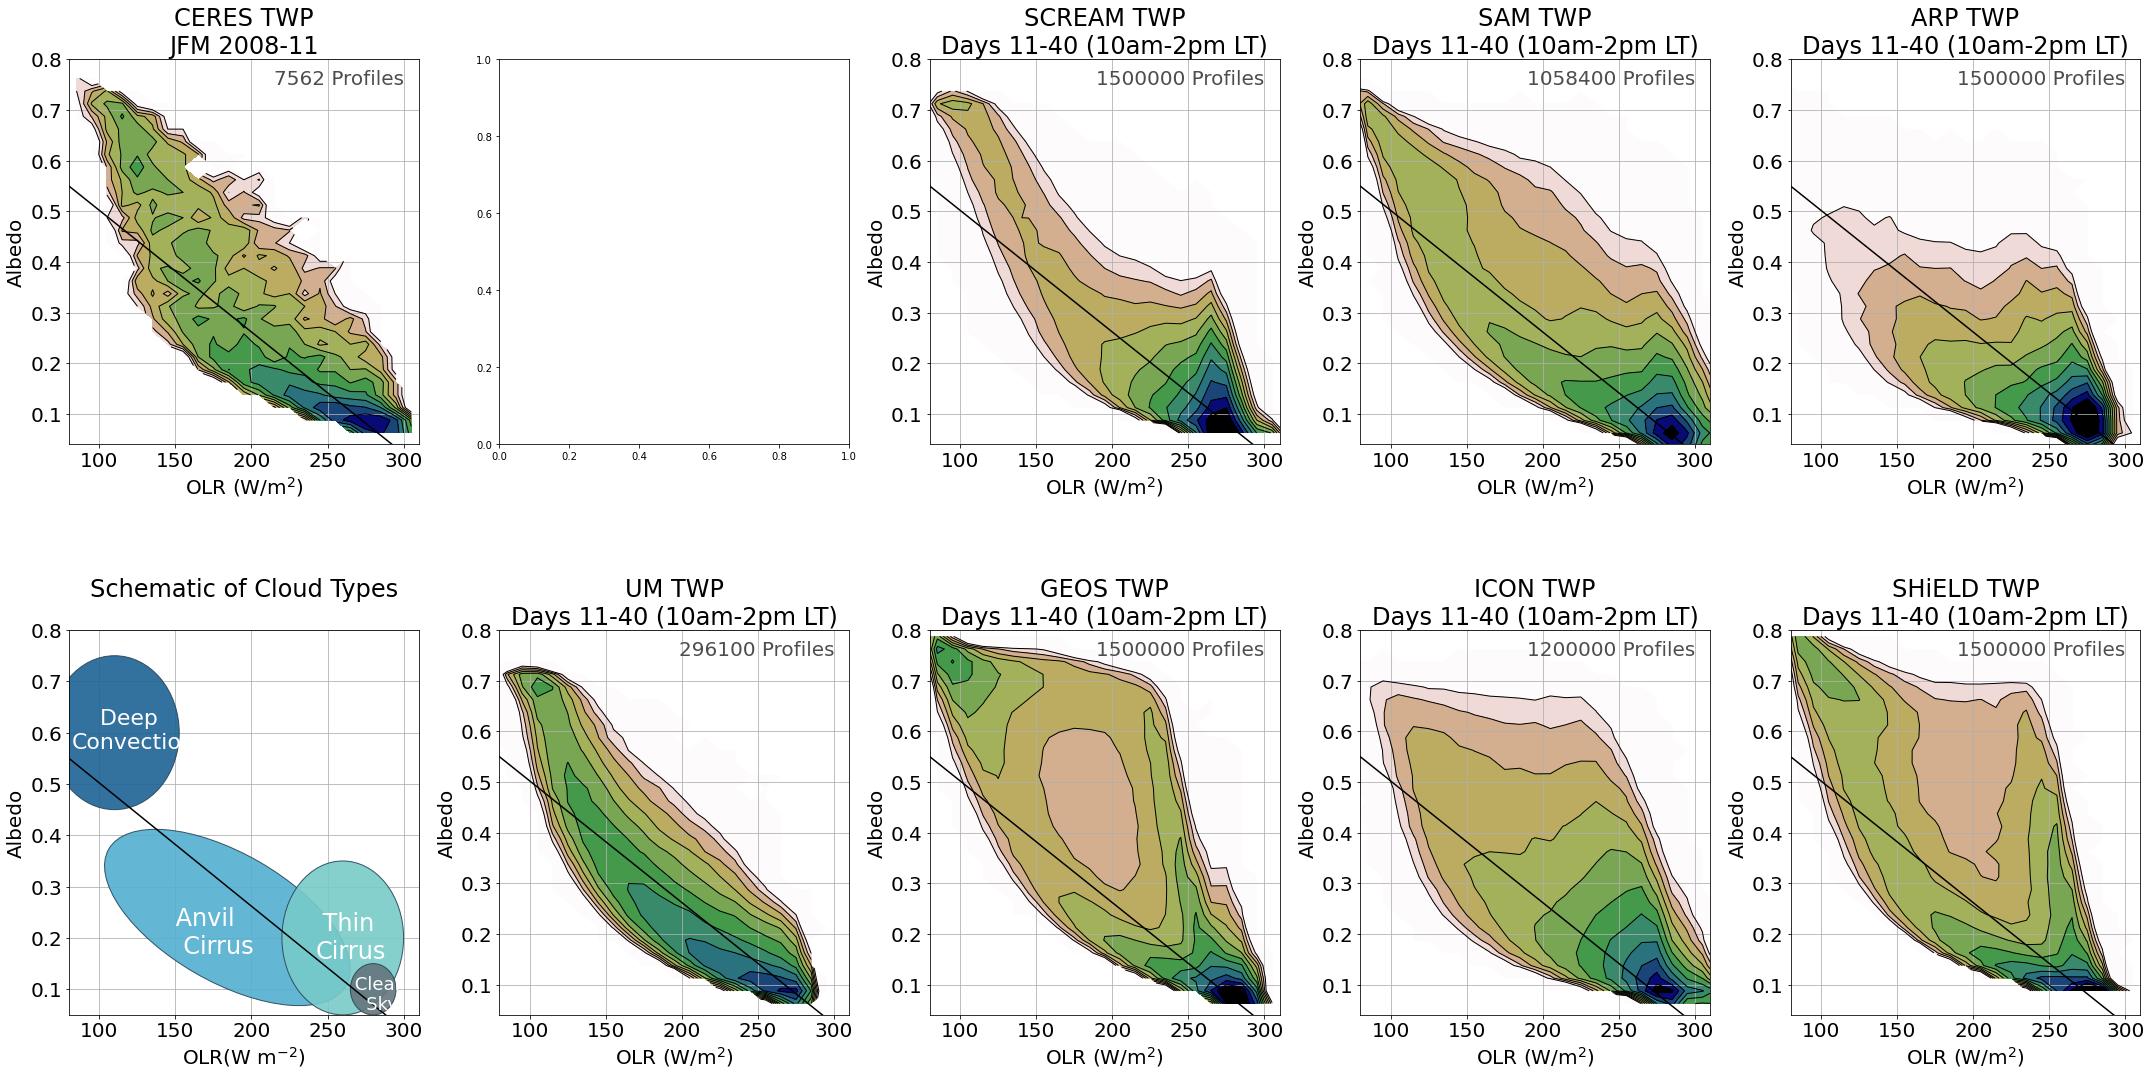

In [19]:
# fig = plt.figure(figsize=(21.5,12))
# axes = [fig.add_subplot(2,4,i) for i in range(1,len(models)+1)]

olrs=dict(zip(["CERES","NICAM","SCREAM","SAM","ARP", "schematic","UM","GEOS","ICON","SHiELD"],
              [da_olr, None, sc_olr, sa_olr, ar_olr, [0], um_olr, ge_olr, ic_olr, sh_olr]))
albs=dict(zip(["CERES","NICAM","SCREAM","SAM","ARP", "schematic","UM","GEOS","ICON","SHiELD"],
              [da_alb, None, sc_alb, sa_alb, ar_alb, [0], um_alb, ge_alb, ic_alb, sh_alb]))

fig = plt.figure(figsize=(30,16))
axes= [fig.add_subplot(2,5,i, box_aspect=1.1) for i in range(1,len(olrs)+1)]
for i,m in enumerate(list(olrs.keys())):
    if olrs[m] is None:
        continue
    if m=="schematic":
        schematic(ax=axes[i], arrow=False)
        continue
    olr = olrs[m]
    alb = albs[m]
    olr = olr.where((olr.time.dt.hour<=4))
    alb = alb.where(alb.time.dt.hour<=4)
    if (m=="CERES") or (not(diff)):
        print(m, olr.shape, alb.shape)
        if olr is None:
            axes[i].axis("off")
        else:
            util.dennisplot("density",olr.values.flatten(), alb.values.flatten(), 
                        ax=axes[i], model=m, region=region,
                        cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), colorbar_on=False)
    else:
        util.dennisplot("difference",[olr.values.flatten(), da_olr.values], [alb.values.flatten(), da_alb.values], 
                    ax=axes[i], model=m, region=region,
                    cmap="bwr", levels=np.arange(-1.5,1.6,0.2), colorbar_on=False)
    axes[i].set_xlabel("OLR (W/m$^2$)")
    axes[i].set_ylabel("Albedo")
    axes[i].grid(True)
    axes[i].set_ylim([0.04,0.8])
    if i==0:
        axes[i].set_title("{} {}\nJFM 2008-11".format(m, region), 
                      fontsize=24)  
    elif diff:
        axes[i].set_title("{} $-$ Obs, {}\nDays 11-40 (10am-2pm LT)".format(m, region), 
                      fontsize=24)
    else:
        axes[i].set_title("{} {}\nDays 11-40 (10am-2pm LT)".format(m, region), 
                      fontsize=24)
    # axes[i].scatter(np.nanmean(olr), np.nanmean(alb), color='r', s=50)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()
if diff:
    region = "diff_"+region
plt.savefig("../plots/TWP/jhist_{}_{}.png".format(n, region))
plt.show()
# region = region.split("_")[-1]

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
1200000


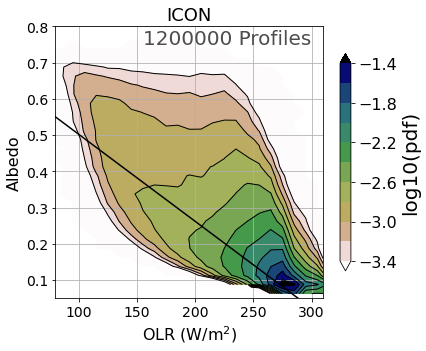

In [15]:
m="ICON"
fs=18
fig, axes = plt.subplots(1,1, figsize=(6,5))
olr = olrs[m]
alb = albs[m]
olr = -olr.where((olr.time.dt.hour>=0)&(olr.time.dt.hour<=4))
alb = alb.where((alb.time.dt.hour>=0)&(alb.time.dt.hour<=4))
util.dennisplot("density",olr.values.flatten(), alb.values.flatten(), 
                ax=axes, model=m, region=region,
                cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), colorbar_on=True)
axes.set_xlabel("OLR (W/m$^2$)", fontsize=fs-2)
axes.set_ylabel("Albedo", fontsize=fs-2)
axes.tick_params(axis="both", labelsize=fs-4)
axes.grid(True)
axes.set_title(m, fontsize=fs)
plt.savefig("../plots/TWP/jhist_{}r0.25deg.png".format(m), dpi=150)
plt.show()


[########################################] | 100% Completed |  0.2s


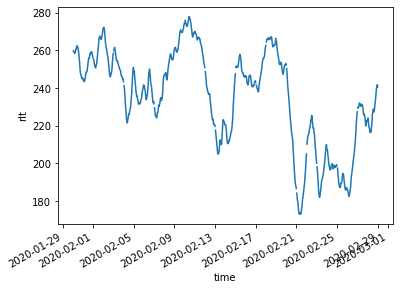

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


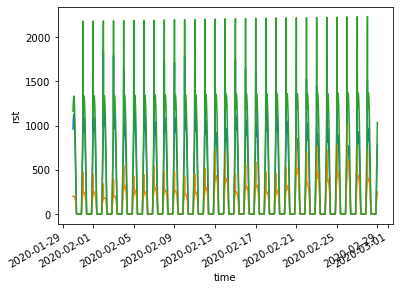

In [20]:
olrs["ICON"].mean(axis=(1,2)).plot()
plt.show()
ic_swn.mean(axis=(1,2)).plot()
ic_swu.mean(axis=(1,2)).plot()
ic_swd.mean(axis=(1,2)).plot()
plt.show()

In [24]:
ic_olr.mean(axis=(1,2))[84].values

[########################################] | 100% Completed |  0.2s


array(245.27, dtype=float32)

In [25]:
ic_olr.min().values, ic_olr.max().values, ic_alb.min().values, ic_alb.max().values

[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s


(array(65.528885, dtype=float32),
 array(326.6667, dtype=float32),
 array(0., dtype=float32),
 array(1., dtype=float32))

In [26]:
# print("DATA:   " + str(int(da_olr.mean().values)) + "   " + str(da_alb.where(da_alb.time.dt.hour<4).mean().values)+\
#       "\nNICAM:  " + str(int(ni_olr.mean().values)) + "   " + str(ni_alb.where(ni_alb.time.dt.hour<4).mean().values)+\
#       "\nSAM:    " + str(int(sa_olr.mean().values)) + "   " + str( sa_alb.where(sa_alb.time.dt.hour<4).mean().values)+\
#       "\nUM:     " + str(int(um_olr.mean().values)) + "   " + str(um_alb.where(um_alb.time.dt.hour<4).mean().values)+\
#       "\nGEOS:   " + str(int(ge_olr.mean().values)) + "   " + str(ge_alb.where(ge_alb.time.dt.hour<4).mean().values)+\
#       "\nSCREAM  " + str(int(sc_olr.mean().values)) + "   " + str(sc_alb.where(sc_alb.time.dt.hour<4).mean().values)
#      )


# CCCM data dyamond 1 vs 2

In [27]:
16.2/3

5.3999999999999995

## density plots for obs


In [ ]:
ds_dict = {"JAS":xr.open_dataset(ap.CCCM_JAS)}
ds_dict["JFM"] = xr.open_dataset(ap.CCCM_JFM)
fig = plt.figure(figsize=(14,7))
axes = [fig.add_subplot(1,2,i) for i in range(1,3)]
cb=False

for i, season in enumerate(["JAS","JFM"]):
    olr = ds_dict[season].CERES_LW_TOA_flux___upwards
    swu = ds_dict[season].CERES_SW_TOA_flux___upwards
    swd = ds_dict[season].TOA_Incoming_Solar_Radiation
    alb = swu/swd.values
    
    olr = olr[~np.isnan(alb)]
    alb = alb[~np.isnan(alb)]
    alb = alb[~np.isnan(olr)]
    olr = olr[~np.isnan(olr)]
    
    util.dennisplot("density",olr.values, alb.values, 
                    ax=axes[i], model="CCCM", region=region, 
                    cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), colorbar_on=cb)
    
    # axes[i].set_xlabel("OLR (W/m$^2$)")
    # axes[i].set_ylabel("Albedo")
    # axes[i].grid(True)
    # axes[i].set_ylim([0,0.8])
    axes[i].set_title("CCCM 20km {}\n{} 2007-10".format(region, season), 
                  fontsize=20)  
    axes[i].scatter(np.nanmean(olr), np.nanmean(alb), color='r', s=50)
# plt.subplots_adjust(wspace=0.05, hspace=0.05)
# plt.tight_layout()
plt.savefig("../plots/TWP/jhist_dy1v2_CCCM.png".format(region),dpi=200)
plt.show()

## difference plot

In [ ]:
ds_dict = {"JAS":xr.open_dataset(ap.CCCM_JAS)}
ds_dict["JFM"] = xr.open_dataset(ap.CCCM_JFM)
seasons = ["JAS","JFM"]

olrs={}
albs={}

for season in seasons:
    olrs[season] = ds_dict[season].CERES_LW_TOA_flux___upwards
    swu = ds_dict[season].CERES_SW_TOA_flux___upwards
    swd = ds_dict[season].TOA_Incoming_Solar_Radiation
    albs[season] = swu/swd.values

fig, ax = plt.subplots(1,1,figsize=(7,6))

util.dennisplot("difference",
                [olrs["JAS"].values,olrs["JFM"].values], 
                [albs["JAS"].values,albs["JFM"].values], 
                ax=ax, model="CCCM 20km", region=region, 
                cmap="bwr", levels=np.arange(-0.9,1,0.2),
                colorbar_on=True)

ax.set_xlabel("OLR (W/m$^2$)")
ax.set_ylabel("Albedo")
ax.grid(True)
ax.set_ylim([0,0.8])
ax.set_title("CCCM 20km {}\nJAS-JFM 2007-10".format(region), 
              fontsize=20)  
# ax.plot([np.nanmean(olrs["JAS"]),np.nanmean(olrs["JFM"])], 
#         [np.nanmean(albs["JAS"]),np.nanmean(albs["JFM"])], 
#         color='r',marker=".",markersize=20,linewidth=5)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()
plt.savefig("../plots/TWP/jhistCCCM_{}_difference.png".format(region))
plt.show()

# DYAMOND 1 v 2 

- density
- difference


In [ ]:
def undomean(meanarray):
    new = xr.DataArray(np.zeros(meanarray.shape), dims=meanarray.dims, coords=meanarray.coords)
    new[1]=meanarray[1]
    for i in np.arange(2,np.shape(meanarray)[0]):
        new[i,:,:] = (i+1)*meanarray[i,:,:] - i*meanarray[i-1,:,:]
    new[0]=np.nan
    new[192]=np.nan
    return new


In [ ]:
m="ICON"

if m=="ARP":
    summer_olr = ap.open_dyamond1(m,"TWP","rlt").rlt/-900
    summer_swn = ap.open_dyamond1(m,"TWP","rst").rst/900
    summer_swd = ap.open_dyamond1("NICAM","TWP","rsdt").rsdt[:,0].interp({"time":summer_swn.time, 
                                                                     "lat":summer_swn.lat, 
                                                                     "lon":summer_swn.lon}, 
                                                                    method="nearest")
    summer_swu = summer_swd.values - summer_swn
elif m=="SAM" or m=="GEOS":
    summer_olr = ap.open_dyamond1(m,"TWP","rlt").rlt
    summer_swn = ap.open_dyamond1(m,"TWP","rst").rst
    summer_swd = ap.open_dyamond1("NICAM","TWP","rsdt").rsdt[:,0].interp({"time":summer_swn.time, 
                                                                     "lat":summer_swn.lat, 
                                                                     "lon":summer_swn.lon}, 
                                                                    method="nearest")
    summer_swu = summer_swd.values - summer_swn
elif m=="ICON":
    summer_olr = -ap.open_dyamond1(m,"TWP","rlt").rlt
    summer_swn = ap.open_dyamond1(m,"TWP","rst").rst
    summer_swu = ap.open_dyamond1(m,"TWP","rsut").rsut
    summer_olr = undomean(summer_olr)
    summer_swn = undomean(summer_swn)
    summer_swu = undomean(summer_swu)
    summer_swd = summer_swu.values + summer_swn
else:
    summer_olr = ap.open_dyamond1(m,"TWP","rlut").rlut
    summer_swu = ap.open_dyamond1(m,"TWP","rsut").rsut
    summer_swd = ap.open_dyamond1(m,"TWP","rsdt").rsdt
summer_alb = summer_swu/summer_swd.where(summer_swd>500).values

In [ ]:
# summer_olr_new.mean(axis=(1,2)).plot()
# # summer_olr.mean(axis=(1,2)).plot()
# plt.show()

fig = plt.figure(figsize=(8,7))
util.dennisplot("density",
                summer_olr.where(summer_olr.time.dt.hour<=4).values.flatten(), 
                summer_alb.where(summer_alb.time.dt.hour<=4).values.flatten(), 
                model="10 Aug$-$10 Sept 2016 "+m, region=region, 
                cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2),
                colorbar_on=True)
plt.show()

In [ ]:
winter_olr = olrs[m].where(olrs[m].time.dt.hour<=4).values.flatten()
winter_alb = albs[m].where(olrs[m].time.dt.hour<=4).values.flatten()
summer_olr = summer_olr.where(summer_olr.time.dt.hour<=4).values.flatten()
summer_alb = summer_alb.where(summer_alb.time.dt.hour<=4).values.flatten()



In [ ]:
summer_olr.shape, summer_alb.shape, winter_olr.shape, winter_alb.shape

## Density plot side by side

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(14,7))
util.dennisplot("density",
                summer_olr, 
                summer_alb, model="10 Aug$-$10 Sept 2016 "+m, region=region, 
                ax=ax[0],
                cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2),
                colorbar_on=False)
util.dennisplot("density",
                winter_olr, 
                winter_alb, model="20 Jan$-$28 Feb 2020 "+m, region=region, 
                ax=ax[1],
                cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2),
                colorbar_on=False)
plt.savefig("../plots/TWP/jhist_dy1v2_{}.png".format(m),dpi=200)
plt.show()

## Difference plot (summer - winter)

In [ ]:
winter_olr = olrs[m]
winter_alb = albs[m]


fig, ax = plt.subplots(1,1,figsize=(7,6))

util.dennisplot("difference",
                [summer_olr, winter_olr], 
                [summer_alb, winter_alb], 
                ax=ax, model=m, region=region, 
                cmap="bwr", levels=np.arange(-0.9,1,0.2),
                colorbar_on=True)

ax.set_xlabel("OLR (W/m$^2$)")
ax.set_ylabel("Albedo")
ax.grid(True)
ax.set_ylim([0,0.8])
ax.set_title("{} {}\nSummer$-$Winter".format(m, region), 
              fontsize=20)  
# ax.plot([np.nanmean(olrs["JAS"]),np.nanmean(olrs["JFM"])], 
#         [np.nanmean(albs["JAS"]),np.nanmean(albs["JFM"])], 
#         color='r',marker=".",markersize=20,linewidth=5)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()
plt.savefig("../plots/TWP/jhist_{}_{}_difference.png".format(m, region))
plt.show()

# GEOS high albedo high OLR values

In [ ]:
ge_iwp = xr.open_dataset(ap.get_file("GEOSr0.25deg", "clivi", "TWP")).clivi
ge_lwp = xr.open_dataset(ap.get_file("GEOSr0.25deg", "clwvi", "TWP")).clwvi
ge_iwp, ge_lwp  

In [ ]:
# t = 2867
# for t in range(t,t+25):
#     fig, ax = plt.subplots(2,2, figsize=(12,10))
    
#     ge_olr[t].plot.pcolormesh(vmin=80, vmax=300, cmap="viridis_r", ax=ax[0,0])
#     ge_alb[t].plot.pcolormesh(vmin=0.05, vmax=0.8, cmap="viridis", ax=ax[0,1], label="Mean alb={0:0.2g}".format(ge_alb[t].mean().values))
#     ax[0,0].annotate("Mean OLR={}".format(int(ge_olr[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
#     ax[0,1].annotate("Mean Alb={0:0.2g}".format((ge_alb[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")

#     print(ge_olr[t].mean().values, ge_alb[t].mean().values)

#     ge_iwp[t].plot.pcolormesh(vmin=1e-5, vmax=1, cmap="viridis", ax=ax[1,0])
#     ge_lwp[t].plot.pcolormesh(vmin=1e-5, vmax=1, cmap="viridis", ax=ax[1,1])
#     ax[1,0].annotate("Mean IWP={0:0.2g} kg/m2".format((ge_iwp[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
#     ax[1,1].annotate("Mean LWP={0:0.2g} kg/m2".format((ge_lwp[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
#     plt.savefig("../plots/TWP/GEOS-albolriwplwp/g{0:0>4}.png".format(t))
#     plt.close()

# SCREAM weird olr alb values


In [ ]:
sc_iwp = xr.open_dataset(ap.get_file("SCREAMr0.25deg", "TWP", "clivi")).clivi
# sc_lwp = xr.open_dataset(ap.get_file("SCREAMr0.25deg", "TWP", "clwvi")).clwvi
sc_iwp#, sc_lwp

In [ ]:
t = 300

# for t in range(t,t+1):
fig, ax = plt.subplots(2,2, figsize=(12,10))

sc_olr[t].plot.pcolormesh(vmin=80, vmax=300, cmap="viridis_r", ax=ax[0,0])
sc_alb[t].plot.pcolormesh(vmin=0.05, vmax=0.8, cmap="viridis", ax=ax[0,1], label="Mean alb={0:0.2g}".format(ge_alb[t].mean().values))
ax[0,0].annotate("Mean OLR={}".format(int(sc_olr[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
ax[0,1].annotate("Mean Alb={0:0.2g}".format((sc_alb[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")

print(ge_olr[t].mean().values, ge_alb[t].mean().values)
# levs = np.logspace(-9,1,25)
# levs = np.linspace(-5,1,12)
sc_iwp[t].plot.pcolormesh(vmin=1e-5, vmax=1, cmap="viridis", ax=ax[1,0]) #  
ax[1,0].set_title(sc_iwp[t].time.values)
# sc_lwp[t].plot.pcolormesh(vmin=1e-5, vmax=1, cmap="viridis", ax=ax[1,1])
ax[1,0].annotate("Mean IWP={0:0.2g} kg/m2".format((sc_iwp[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
# ax[1,1].annotate("Mean LWP={0:0.2g} kg/m2".format((ge_lwp[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
plt.savefig("../plots/TWP/SCREAM-albolriwplwp/s{0:0>4}.png".format(t))
plt.show()

In [ ]:
plt.hist2d(sc_iwp.values.flatten(), sc_olr.values.flatten(), density=True, 
           bins=[np.logspace(-7,2,25), np.linspace(80,310,26)])# np.linspace(0,1,26)])# 
plt.xscale('log')
plt.colorbar()
plt.show()

In [ ]:
sc_olr.shape, sc_alb.shape, sc_iwp.shape

In [ ]:
# util.dennisplot("mean",sc_olr.values.flatten(), sc_alb.values.flatten(), var=sc_iwp.values.flatten())

# GT TTL cld frac

In [ ]:
da = xr.open_dataset(ap.GT+"GT/